In [236]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [250]:
def load_data(path="../train.tsv", length=5000):
    df = pd.read_csv(path, sep="\t")[:length]
    df.drop(['PhraseId','SentenceId'], axis=1, inplace=True)
    x, y = df["Phrase"].values, df["Sentiment"].values
    return (x, y)

x, y = load_data("../train.tsv")

def clean_text(x, y):
  x = [i.lower() for i in x]
  x = [re.sub(r'[^A-Za-z]+', ' ', i) for i in x]
  x_, y_ = [], []
  for i in range(len(x)):
    if x[i].split():
      x_.append(x[i])
      y_.append(y[i])
  return x_, y_

x, y = clean_text(x, y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print(len(x), len(x_train), len(x_val))
print(x[:5], y[:5])

4980 3984 996
['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story ', 'a series of escapades demonstrating the adage that what is good for the goose', 'a series', 'a', 'series'] [1, 2, 2, 2, 2]


In [269]:
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x)

word2inx = {d[i]:i for i in range(len(d))}

pad_idx = len(word2inx)

word2inx["padding"] = pad_idx

vocab_size = len(word2inx)

n_classes = 5

print(len(word2inx))


1459


In [270]:
batch_size = 64

class mydataset(torch.utils.data.Dataset):
    def __init__(self, x:torch.Tensor, y:torch.Tensor, length_list):
        self.x = x
        self.y = y
        self.length_list = length_list
    def __getitem__(self, index):
        data = self.x[index]
        labels = self.y[index]
        length = self.length_list[index]
        return data, labels, length
    def __len__(self):
        return len(self.x)

def sentence2vector(sentence):
    return [word2inx[word] for word in sentence.split()]

def padding(x, max_length):
    length = 0
    for i in range(max_length - len(x)):
        x.append(word2inx["padding"])
    return x

def get_dataloader(x, y):
    inputs = [sentence2vector(s) for s in x]

    length_list = [len(i) for i in inputs]

    max_length = max(length_list)

    inputs = torch.tensor([padding(s, max_length) for s in inputs])

    targets =  torch.tensor(y, dtype=torch.long)

    da = mydataset(inputs, targets, length_list)

    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)

    return dataloader


train_dataloader = get_dataloader(x_train, y_train)

test_dataloader = get_dataloader(x_val, y_val)


In [253]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, vocab_size, target_size, dropout, embedding):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        if embedding is None:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        else:
            self.word_embeddings = embedding
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, bidirectional=True)

        self.hidden2tag = nn.Linear(2 * hidden_dim, target_size)

    def forward(self, sentences, length_list):

        embeds = self.word_embeddings(sentences)

        packed_x = pack_padded_sequence(embeds, lengths=length_list, batch_first=True, enforce_sorted=False)

        packed_out, (h, C) = self.lstm(packed_x)
        y_ = self.hidden2tag(torch.cat((h[-2], h[-1]), dim=1))
        return y_

loss_function = nn.CrossEntropyLoss()

net = LSTM(100, 20, 20, vocab_size, n_classes, 0.6, None)

optimizer = optim.SGD(net.parameters(), lr=0.1)

for i, (inputs, targets, length_list) in enumerate(train_dataloader):
    net.zero_grad()
    
    probs = net(inputs, length_list)

    print(probs, targets)

    loss = loss_function(probs, targets)

    loss.backward()

    optimizer.step()
    break



tensor([[-2.5913e-01,  1.0747e-02,  2.3679e-02, -1.4752e-01, -3.0481e-02],
        [-2.3009e-01,  2.6177e-02,  2.1855e-02, -1.5808e-01, -2.1182e-02],
        [-1.9870e-01, -1.7241e-02,  3.5334e-02, -1.2226e-01, -3.3691e-02],
        [-1.8063e-01, -1.1752e-02,  3.6020e-02, -9.0894e-02, -8.0283e-03],
        [-1.8213e-01, -8.6037e-03,  3.9190e-02, -1.0210e-01, -2.0225e-02],
        [-2.2857e-01,  1.9604e-03, -7.2726e-03, -1.3940e-01, -3.1061e-02],
        [-1.7550e-01, -2.1461e-02,  3.8015e-02, -1.1112e-01, -2.3064e-02],
        [-2.1983e-01, -6.9458e-03,  2.6802e-02, -1.2410e-01, -4.6700e-02],
        [-1.7274e-01, -2.0264e-02,  4.8102e-02, -8.8720e-02, -2.3054e-02],
        [-2.4365e-01, -4.7844e-03,  1.6385e-02, -1.2541e-01, -1.3808e-02],
        [-2.2779e-01, -8.8964e-03,  2.8355e-02, -1.4109e-01, -2.9583e-02],
        [-1.7515e-01, -5.0564e-03,  3.5304e-02, -9.3359e-02, -2.3369e-03],
        [-1.8292e-01, -2.8010e-02,  3.8743e-02, -1.1746e-01, -3.5443e-02],
        [-1.7415e-01, -2.

epoch:  0 batch:  1280  time:  8.1 loss:  33.196224212646484
epoch:  1 batch:  1280  time:  19.8 loss:  28.525990962982178
epoch:  2 batch:  1280  time:  31.4 loss:  24.984364092350006
epoch:  3 batch:  1280  time:  44.3 loss:  23.113911151885986
epoch:  4 batch:  1280  time:  56.6 loss:  22.50793766975403
epoch:  5 batch:  1280  time:  1m8.2 loss:  22.19699603319168
epoch:  6 batch:  1280  time:  1m19.8 loss:  22.254164695739746
epoch:  7 batch:  1280  time:  1m31.8 loss:  22.21861106157303
epoch:  8 batch:  1280  time:  1m44.0 loss:  22.001746773719788
epoch:  9 batch:  1280  time:  1m57.6 loss:  22.06411647796631


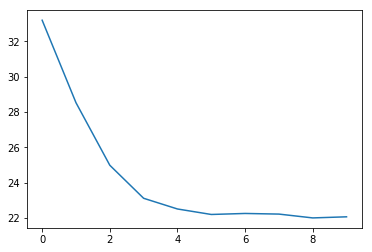

In [254]:
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m " + str(round(time % 60, degree)) if time > 60 else round(time, degree)

net = LSTM(100, 20, 20, vocab_size, n_classes, 0.6, None)

def train():
    
    criterion =  nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=0.001)

    epoch = 10

    start_time = time.time()

    loss_list = []

    for i in range(epoch):
        total_loss = 0.
        for j, (inputs, targets, length_list) in enumerate(train_dataloader):
            probs = net(inputs, length_list)

            net.zero_grad()
  
            loss = criterion(probs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            log_interval = len(x_train)

            if  j % 100 == 0 and j:
                time_past = time.time() - start_time
                cur_loss = total_loss
                loss_list.append(cur_loss)
                total_loss = 0
                print("epoch: ", i, "batch: ", round(j * batch_size, len(x_train)), " time: ", pretty_time(time_past), "loss: ", cur_loss)

    plt.plot(loss_list)

    plt.show()
    
train()

In [273]:
def test():
    count = 0
    i = 0
    from collections import Counter
    with torch.no_grad():
        for j, (inputs, targets, length_list) in enumerate(test_dataloader):
            probs = net(inputs, length_list)
            count += Counter((torch.argmax(probs, dim=1) - targets).tolist())[0]
            i = j
    print("acc_val: ", count / (j*batch_size))
    distribution = Counter(y_val)
    print(distribution)
    print([i/len(y_val) for i in distribution.values()])


test()

acc_val:  0.6229838709677419
Counter({2: 597, 3: 173, 1: 147, 4: 49, 0: 30})
[0.5993975903614458, 0.14759036144578314, 0.04919678714859438, 0.030120481927710843, 0.17369477911646586]
